Ye ab tak ka code:

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


def process_image(frame):
    
    def cal_undistort(img):
        # Reads mtx and dist matrices, peforms image distortion correction and returns the undistorted image

        import pickle

        # Read in the saved matrices
        my_dist_pickle = pickle.load( open( "output_files/calib_pickle_files/dist_pickle.p", "rb" ) )
        mtx = my_dist_pickle["mtx"]
        dist = my_dist_pickle["dist"]

        img_size = (img.shape[1], img.shape[0])    

        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        #undistorted_img =  cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)   #Use if you use cv2 to import image. ax.imshow() needs RGB image
        return undistorted_img

    
    def yellow_threshold(img, sxbinary):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        h_channel = hls[:,:,0]
        # Threshold color channel
        s_thresh_min = 100
        s_thresh_max = 255
        
        #for 360 degree, my value for yellow ranged between 35 and 50. So uska half kar diya
        h_thresh_min = 10    
        h_thresh_max = 25

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel >= h_thresh_min) & (h_channel <= h_thresh_max)] = 1

        # Combine the two binary thresholds
        yellow_binary = np.zeros_like(s_binary)
        yellow_binary[(((s_binary == 1) | (sxbinary == 1) ) & (h_binary ==1))] = 1
        return yellow_binary
    
    def xgrad_binary(img, thresh_min=30, thresh_max=100):
        # Grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        # Threshold x gradient
        #thresh_min = 30    #Already given above
        #thresh_max = 100

        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def white_threshold(img, sxbinary, lower_white_thresh = 170):
        r_channel = img[:,:,0]
        g_channel = img[:,:,1]
        b_channel = img[:,:,2]
        # Threshold color channel
        r_thresh_min = lower_white_thresh
        r_thresh_max = 255
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel >= r_thresh_min) & (r_channel <= r_thresh_max)] = 1
        
        g_thresh_min = lower_white_thresh
        g_thresh_max = 255
        g_binary = np.zeros_like(g_channel)
        g_binary[(g_channel >= g_thresh_min) & (g_channel <= g_thresh_max)] = 1

        b_thresh_min = lower_white_thresh
        b_thresh_max = 255
        b_binary = np.zeros_like(b_channel)
        b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

        white_binary = np.zeros_like(r_channel)
        white_binary[((r_binary ==1) & (g_binary ==1) & (b_binary ==1) & (sxbinary==1))] = 1
        return white_binary
        
    def thresh_img(img):
                       
       
        #sxbinary = xgrad_binary(img, thresh_min=30, thresh_max=100)
        sxbinary = xgrad_binary(img, thresh_min=25, thresh_max=130)
        yellow_binary = yellow_threshold(img, sxbinary)     #(((s) | (sx)) & (h))
        white_binary = white_threshold(img, sxbinary, lower_white_thresh = 150)
        
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[((yellow_binary == 1) | (white_binary == 1))] = 1
        
        out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
        
        return out_img
    
    def perspective_transform(img):
    
        # Define calibration box in source (original) and destination (desired or warped) coordinates

        img_size = (img.shape[1], img.shape[0])
        """Notice the format used for img_size. Yaha bhi ulta hai. x axis aur fir y axis chahiye. 
              Apne format mein rows(y axis) and columns (x axis) hain"""


        # Four source coordinates
        # Order of points: top left, top right, bottom right, bottom left
        
        src = np.array(
            [[435*img.shape[1]/960, 350*img.shape[0]/540],
             [530*img.shape[1]/960, 350*img.shape[0]/540],
             [885*img.shape[1]/960, img.shape[0]],
             [220*img.shape[1]/960, img.shape[0]]], dtype='f')
        

        # Next, we'll define a desired rectangle plane for the warped image.
        # We'll choose 4 points where we want source points to end up 
        # This time we'll choose our points by eyeballing a rectangle

        dst = np.array(
            [[290*img.shape[1]/960, 0],
             [740*img.shape[1]/960, 0],
             [740*img.shape[1]/960, img.shape[0]],
             [290*img.shape[1]/960, img.shape[0]]], dtype='f')


        #Compute the perspective transform, M, given source and destination points:
        M = cv2.getPerspectiveTransform(src, dst)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
              
        return warped, src, dst 

    def rev_perspective_transform(img, src, dst):

        img_size = (img.shape[1], img.shape[0])

        #Compute the perspective transform, M, given source and destination points:
        Minv = cv2.getPerspectiveTransform(dst, src)

        #Warp an image using the perspective transform, M; using linear interpolation    
        #Interpolating points is just filling in missing points as it warps an image
        # The input image for this function can be a colored image too
        un_warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
              
        return un_warped 

    
    def draw_polygon(img1, img2, src, dst):
        src = src.astype(int)  #Very important step (Pixels cannot be in decimals)
        dst = dst.astype(int)
        cv2.polylines(img1, [src], True, (255,0,0), 3)
        cv2.polylines(img2, [dst], True, (255,0,0), 3)
    
    def histogram_bottom_peaks (warped_img):
        # This will detect the bottom point of our lane lines
        
        # Take a histogram of the bottom half of the image
        bottom_half = warped_img[((2*warped_img.shape[0])//5):,:,0]     # Collecting all pixels in the bottom half
        histogram = np.sum(bottom_half, axis=0)                         # Summing them along y axis (or along columns)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)        # 1D array hai histogram toh uska bas 0th index filled hoga 
        #print(np.shape(histogram))     #OUTPUT:(1280,)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        return leftx_base, rightx_base
    
    def find_lane_pixels(warped_img):
    
        leftx_base, rightx_base = histogram_bottom_peaks(warped_img)
   
        
        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = 9
        # Set the width of the windows +/- margin. So width = 2*margin 
        margin = 90
        # Set minimum number of pixels found to recenter window
        minpix = 1000    #I've changed this from 50 as given in lectures
    
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(warped_img.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = warped_img.nonzero()  #pixel ke coordinates dega 2 seperate arrays mein
        nonzeroy = np.array(nonzero[0])    # Y coordinates milenge 1D array mein. They will we arranged in the order of pixels
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base         #initially set kar diya hai. For loop ke end mein change karenge
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []   # Ismein lane-pixels ke indices collect karenge. 
                              # 'nonzerox' array mein index daalke coordinate mil jaayega
        right_lane_inds = []  

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_img.shape[0] - (window+1)*window_height
            win_y_high = warped_img.shape[0] - window*window_height
            """### TO-DO: Find the four below boundaries of the window ###"""
            win_xleft_low = leftx_current - margin  
            win_xleft_high = leftx_current + margin  
            win_xright_low = rightx_current - margin  
            win_xright_high = rightx_current + margin 
            
            """
            # Create an output image to draw on and visualize the result
            out_img = np.copy(warped_img)
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
            """

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            #Iska poora explanation seperate page mein likha hai
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]


            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            # If you found > minpix pixels, recenter next window on the mean position of the pixels in your current window (re-centre)
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        """return leftx, lefty, rightx, righty, out_img""" #agar rectangles bana rahe ho toh out_image rakhna
        return leftx, lefty, rightx, righty
        

    def fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_fit_history, right_variance_history):
    
        #Fit a second order polynomial to each using `np.polyfit` ###
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)

        # Generate x and y values for plotting. 
        #NOTE: y is the independent variable. Refer "fit polynomial" notes for explanation
        # We'll plot x as a function of y
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        
        # Eqn of parabola: a(x**2) + bx + c. Where a and b denote the shape of parabola. Shape of parabola will be amost constant inn our case 
        
        variance_new=0  #initializing the variable
        
        try:        
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            
            if(right_fit_history == None):
                a2 = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2 = (0.6*left_fit[1] + 0.4*right_fit[1])
                c2 = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                for index in range(len(rightx)):
                    variance_new+= abs(rightx[index]-(a2*righty[index]**2 + b2*righty[index] + c2))
                variance_new=variance_new/len(rightx)
                print("variance_new",variance_new)
                
            else:
                a2_new = (0.6*left_fit[0] + 0.4*right_fit[0])
                b2_new = (0.6*left_fit[1] + 0.4*right_fit[1])  
                c2_new = (warped_img.shape[1] - (left_fit[0]*(warped_img.shape[0]-1)**2 + left_fit[1]*(warped_img.shape[0]-1) + left_fit[2]))*0.1 + 0.9*right_fit[2]
                
                # Finding weighted average for the previous elements data within right_fit_history
                a2_old= sum([(0.2*(index+1)*element[0]) for index,element in enumerate(right_fit_history)])/sum([0.2*(index+1) for index in range(0,5)])        
                b2_old= sum([(0.2*(index+1)*element[1]) for index,element in enumerate(right_fit_history)])/sum([0.2*(index+1) for index in range(0,5)])       
                c2_old= sum([(0.2*(index+1)*element[2]) for index,element in enumerate(right_fit_history)])/sum([0.2*(index+1) for index in range(0,5)])
                
                """Trying to find variance"""
                
                for index in range(len(rightx)):
                    variance_new+= abs(rightx[index]-(a2_new*righty[index]**2 + b2_new*righty[index] + c2_new))
                variance_new=variance_new/len(rightx)
                print("variance_new",variance_new)
                
                
                #variance_old = sum([(0.2*(index+1)*element[0]) for index,element in enumerate(right_variance_history)])/sum([0.2*(index+1) for index in range(0,5)])
                variance_old = right_variance_history[4]
                
                """yaha ke coefficients variance se aa sakte hain"""
                coeff_new=variance_old/(variance_new+variance_old)
                coeff_old=variance_new/(variance_new+variance_old)
                
                a2= a2_new*coeff_new + a2_old*coeff_old
                b2= b2_new*coeff_new + b2_old*coeff_old
                c2= c2_new*coeff_new + c2_old*coeff_old
            
            
            right_fitx = a2*ploty**2 + b2*ploty + c2
            
            status = True
        
        #try:
        #    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty
            status = False

        
        return left_fit, [a2,b2,c2], left_fitx, right_fitx, status, variance_new
        # out_img here has boxes drawn and the pixels are colored 
    
    def color_pixels_and_curve(out_img, leftx, lefty, rightx, righty, left_fitx, right_fitx):
        ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        
        # Converting the coordinates of our line into integer values as index of the image can't take decimals
        left_fitx_int = left_fitx.astype(np.int32)
        right_fitx_int = right_fitx.astype(np.int32)
        ploty_int = ploty.astype(np.int32)
        
        # Coloring the curve as yellow
        out_img[ploty_int,left_fitx_int] = [255,255,0]
        out_img[ploty_int,right_fitx_int] = [255,255,0]
        
        # To thicken the curve
        out_img[ploty_int,left_fitx_int+1] = [255,255,0]
        out_img[ploty_int,right_fitx_int+1] = [255,255,0]
        out_img[ploty_int,left_fitx_int-1] = [255,255,0]
        out_img[ploty_int,right_fitx_int-1] = [255,255,0]
        out_img[ploty_int,left_fitx_int+2] = [255,255,0]
        out_img[ploty_int,right_fitx_int+2] = [255,255,0]
        out_img[ploty_int,left_fitx_int-2] = [255,255,0]
        out_img[ploty_int,right_fitx_int-2] = [255,255,0]
        
        
        
    def search_around_poly(warped_img, left_fit, right_fit):
        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### TO-DO: Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        ### Hint: consider the window areas for the similarly named variables ###
        ### in the previous quiz, but change the windows to our new search area ###
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty

    def modify_array(array, new_value):
        if len(array)!=5:
            for i in range(0,5):
                array.append(new_value)

        else:
            dump_var=array[0]
            array[0]=array[1]
            array[1]=array[2]
            array[2]=array[3]
            array[3]=array[4]
            array[4]=new_value
        return array

    undist_img = cal_undistort(frame)
    thresh_img = thresh_img(undist_img)    # Note: This is not a binary iamge. It has been stacked already within the function
    warped_img, src, dst = perspective_transform(thresh_img)

    #draw_polygon(frame, warped_img, src, dst)   #the first image is the original image that you import into the system
    
    print("starting count",lane.count)
    if (lane.count == 0):
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)     # Find our lane pixels first
        left_fit, right_fit, left_fitx, right_fitx, status, variance_new = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_fit_history=None, right_variance_history=None)
        print("First case mein variance ye hai", variance_new)
    elif (lane.count > 0):
        
        left_fit_previous = [i[0] for i in lane.curve_fit] 
        right_fit_previous = [i[1] for i in lane.curve_fit]
        
        #print(left_fit_previous)
        #print(right_fit_previous)
        leftx, lefty, rightx, righty = search_around_poly(warped_img, left_fit_previous[4], right_fit_previous[4])
        left_fit, right_fit, left_fitx, right_fitx, status, variance_new = fit_polynomial(warped_img, leftx, lefty, rightx, righty, right_fit_history=right_fit_previous, right_variance_history=lane.right_variance)
        
    color_pixels_and_curve(warped_img, leftx, lefty, rightx, righty, left_fitx, right_fitx)
    
    lane.detected = status
    lane.curve_fit = modify_array(lane.curve_fit,[left_fit, right_fit])
    lane.right_variance = modify_array(lane.right_variance, variance_new)
    print(lane.right_variance)
    
    #lane.current_xfitted.append([left_fitx, right_fitx])
    #lane.allx.append([leftx,rightx])
    #lane.ally.append([lefty, righty])
    #lane.image_output.append(warped_img)
    
    unwarped_img = rev_perspective_transform(warped_img, src, dst)
    
    lane.count = lane.count+1
    return unwarped_img
    
    

Let's try classes

starting count value 0
starting count 0
variance_new 16.411728943874007
First case mein variance ye hai 16.411728943874007
[16.411728943874007, 16.411728943874007, 16.411728943874007, 16.411728943874007, 16.411728943874007]
starting count 1
variance_new 20.454135208135213
[16.411728943874007, 16.411728943874007, 16.411728943874007, 16.411728943874007, 20.454135208135213]
starting count 2
variance_new 14.975480798140142
[16.411728943874007, 16.411728943874007, 16.411728943874007, 20.454135208135213, 14.975480798140142]


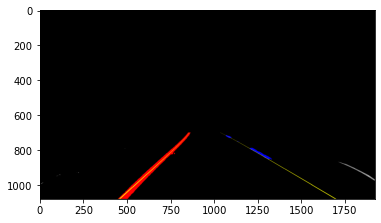

In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.right_variance = []
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        
        
lane=Line()


frame1= mpimg.imread("my_test_images/Highway_snaps/image (1).jpg")
frame2= mpimg.imread("my_test_images/Highway_snaps/image (2).jpg")
frame3= mpimg.imread("my_test_images/Highway_snaps/image (3).jpg")


print("starting count value",lane.count)


(process_image(frame1))
(process_image(frame2))
plt.imshow(process_image(frame3))


Videoo test



In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        #Let's count the number of consecutive frames
        self.count = 0
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients for the most recent fit
        self.curve_fit = []  
        # Traking variance for the right lane
        self.right_variance = []
        # x values of the curve that we fit intially
        #self.current_xfitted = []
        # x values for detected line pixels
        #self.allx = []  
        # y values for detected line pixels
        #self.ally = []
        #store your image in this
        #self.image_output = []
        
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')      
        
lane=Line()

project_output = 'output_files/video_clips/project_video_with_history.mp4'

#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4").subclip(20,23)

project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images! 
%time project_clip.write_videofile(project_output, audio=False)

starting count 0


t:   0%|          | 0/75 [00:00<?, ?it/s, now=None]

variance_new 17.16166322178149
First case mein variance ye hai 17.16166322178149
[17.16166322178149, 17.16166322178149, 17.16166322178149, 17.16166322178149, 17.16166322178149]
Moviepy - Building video output_files/video_clips/project_video_with_history.mp4.
Moviepy - Writing video output_files/video_clips/project_video_with_history.mp4

starting count 1


t:   3%|▎         | 2/75 [00:00<00:20,  3.56it/s, now=None]

variance_new 17.161663221780987
[17.16166322178149, 17.16166322178149, 17.16166322178149, 17.16166322178149, 17.161663221780987]
starting count 2


t:   4%|▍         | 3/75 [00:01<00:24,  3.00it/s, now=None]

variance_new 19.85226422584972
[17.16166322178149, 17.16166322178149, 17.16166322178149, 17.161663221780987, 19.85226422584972]
starting count 3


t:   5%|▌         | 4/75 [00:01<00:29,  2.44it/s, now=None]

variance_new 18.315758841642694
[17.16166322178149, 17.16166322178149, 17.161663221780987, 19.85226422584972, 18.315758841642694]
starting count 4


t:   7%|▋         | 5/75 [00:02<00:28,  2.44it/s, now=None]

variance_new 19.418756667436835
[17.16166322178149, 17.161663221780987, 19.85226422584972, 18.315758841642694, 19.418756667436835]
starting count 5


t:   8%|▊         | 6/75 [00:02<00:28,  2.46it/s, now=None]

variance_new 21.827567630648268
[17.161663221780987, 19.85226422584972, 18.315758841642694, 19.418756667436835, 21.827567630648268]
starting count 6


t:   9%|▉         | 7/75 [00:03<00:31,  2.16it/s, now=None]

variance_new 19.79881415593422
[19.85226422584972, 18.315758841642694, 19.418756667436835, 21.827567630648268, 19.79881415593422]
starting count 7


t:  11%|█         | 8/75 [00:03<00:29,  2.26it/s, now=None]

variance_new 19.748209889390704
[18.315758841642694, 19.418756667436835, 21.827567630648268, 19.79881415593422, 19.748209889390704]
starting count 8


t:  12%|█▏        | 9/75 [00:03<00:30,  2.14it/s, now=None]

variance_new 18.320790741410505
[19.418756667436835, 21.827567630648268, 19.79881415593422, 19.748209889390704, 18.320790741410505]
starting count 9


t:  13%|█▎        | 10/75 [00:04<00:30,  2.10it/s, now=None]

variance_new 19.24179710597314
[21.827567630648268, 19.79881415593422, 19.748209889390704, 18.320790741410505, 19.24179710597314]
starting count 10


t:  15%|█▍        | 11/75 [00:04<00:28,  2.28it/s, now=None]

variance_new 15.27651711114638
[19.79881415593422, 19.748209889390704, 18.320790741410505, 19.24179710597314, 15.27651711114638]
starting count 11


t:  16%|█▌        | 12/75 [00:05<00:26,  2.38it/s, now=None]

variance_new 13.958370996780241
[19.748209889390704, 18.320790741410505, 19.24179710597314, 15.27651711114638, 13.958370996780241]
starting count 12


t:  17%|█▋        | 13/75 [00:05<00:27,  2.26it/s, now=None]

variance_new 16.00696490770333
[18.320790741410505, 19.24179710597314, 15.27651711114638, 13.958370996780241, 16.00696490770333]
starting count 13


t:  19%|█▊        | 14/75 [00:06<00:29,  2.06it/s, now=None]

variance_new 15.451624497365907
[19.24179710597314, 15.27651711114638, 13.958370996780241, 16.00696490770333, 15.451624497365907]
starting count 14


t:  20%|██        | 15/75 [00:06<00:31,  1.91it/s, now=None]

variance_new 16.483668594769377
[15.27651711114638, 13.958370996780241, 16.00696490770333, 15.451624497365907, 16.483668594769377]
starting count 15


t:  21%|██▏       | 16/75 [00:07<00:28,  2.11it/s, now=None]

variance_new 18.280824312214065
[13.958370996780241, 16.00696490770333, 15.451624497365907, 16.483668594769377, 18.280824312214065]
starting count 16


t:  23%|██▎       | 17/75 [00:07<00:27,  2.08it/s, now=None]

variance_new 20.495319660576722
[16.00696490770333, 15.451624497365907, 16.483668594769377, 18.280824312214065, 20.495319660576722]
starting count 17
variance_new 19.980981183832515


t:  24%|██▍       | 18/75 [00:08<00:26,  2.13it/s, now=None]

[15.451624497365907, 16.483668594769377, 18.280824312214065, 20.495319660576722, 19.980981183832515]
starting count 18


t:  25%|██▌       | 19/75 [00:08<00:26,  2.09it/s, now=None]

variance_new 18.533006259600654
[16.483668594769377, 18.280824312214065, 20.495319660576722, 19.980981183832515, 18.533006259600654]
starting count 19


t:  27%|██▋       | 20/75 [00:09<00:24,  2.22it/s, now=None]

variance_new 20.68064650470634
[18.280824312214065, 20.495319660576722, 19.980981183832515, 18.533006259600654, 20.68064650470634]


t:  28%|██▊       | 21/75 [00:09<00:23,  2.31it/s, now=None]

starting count 20
variance_new 17.837780370945104
[20.495319660576722, 19.980981183832515, 18.533006259600654, 20.68064650470634, 17.837780370945104]


t:  29%|██▉       | 22/75 [00:09<00:20,  2.55it/s, now=None]

starting count 21
variance_new 15.304905501824617
[19.980981183832515, 18.533006259600654, 20.68064650470634, 17.837780370945104, 15.304905501824617]


t:  31%|███       | 23/75 [00:10<00:20,  2.57it/s, now=None]

starting count 22
variance_new 11.309793161383913
[18.533006259600654, 20.68064650470634, 17.837780370945104, 15.304905501824617, 11.309793161383913]
starting count 23


t:  32%|███▏      | 24/75 [00:10<00:20,  2.51it/s, now=None]

variance_new 11.506443173286387
[20.68064650470634, 17.837780370945104, 15.304905501824617, 11.309793161383913, 11.506443173286387]
starting count 24


t:  33%|███▎      | 25/75 [00:11<00:22,  2.24it/s, now=None]

variance_new 12.318295129954612
[17.837780370945104, 15.304905501824617, 11.309793161383913, 11.506443173286387, 12.318295129954612]
starting count 25


t:  35%|███▍      | 26/75 [00:11<00:20,  2.40it/s, now=None]

variance_new 12.113099308127504
[15.304905501824617, 11.309793161383913, 11.506443173286387, 12.318295129954612, 12.113099308127504]
starting count 26


t:  36%|███▌      | 27/75 [00:11<00:19,  2.49it/s, now=None]

variance_new 16.93375243391508
[11.309793161383913, 11.506443173286387, 12.318295129954612, 12.113099308127504, 16.93375243391508]
starting count 27


t:  37%|███▋      | 28/75 [00:12<00:18,  2.50it/s, now=None]

variance_new 17.253132683104695
[11.506443173286387, 12.318295129954612, 12.113099308127504, 16.93375243391508, 17.253132683104695]
starting count 28


t:  39%|███▊      | 29/75 [00:12<00:18,  2.48it/s, now=None]

variance_new 19.47981083216013
[12.318295129954612, 12.113099308127504, 16.93375243391508, 17.253132683104695, 19.47981083216013]
starting count 29


t:  40%|████      | 30/75 [00:12<00:17,  2.60it/s, now=None]

variance_new 18.753292080417452
[12.113099308127504, 16.93375243391508, 17.253132683104695, 19.47981083216013, 18.753292080417452]
starting count 30


t:  41%|████▏     | 31/75 [00:13<00:16,  2.66it/s, now=None]

variance_new 14.32255071015527
[16.93375243391508, 17.253132683104695, 19.47981083216013, 18.753292080417452, 14.32255071015527]
starting count 31
variance_new 11.809237593052307


t:  43%|████▎     | 32/75 [00:13<00:16,  2.59it/s, now=None]

[17.253132683104695, 19.47981083216013, 18.753292080417452, 14.32255071015527, 11.809237593052307]
starting count 32


t:  44%|████▍     | 33/75 [00:14<00:15,  2.63it/s, now=None]

variance_new 12.523146816979644
[19.47981083216013, 18.753292080417452, 14.32255071015527, 11.809237593052307, 12.523146816979644]
starting count 33


t:  45%|████▌     | 34/75 [00:14<00:16,  2.42it/s, now=None]

variance_new 14.881124975593991
[18.753292080417452, 14.32255071015527, 11.809237593052307, 12.523146816979644, 14.881124975593991]
starting count 34


t:  47%|████▋     | 35/75 [00:14<00:16,  2.49it/s, now=None]

variance_new 14.1323805912951
[14.32255071015527, 11.809237593052307, 12.523146816979644, 14.881124975593991, 14.1323805912951]
starting count 35


t:  48%|████▊     | 36/75 [00:15<00:15,  2.52it/s, now=None]

variance_new 17.267577857686785
[11.809237593052307, 12.523146816979644, 14.881124975593991, 14.1323805912951, 17.267577857686785]
starting count 36


t:  49%|████▉     | 37/75 [00:15<00:15,  2.45it/s, now=None]

variance_new 22.203733601582343
[12.523146816979644, 14.881124975593991, 14.1323805912951, 17.267577857686785, 22.203733601582343]
starting count 37


t:  51%|█████     | 38/75 [00:16<00:16,  2.30it/s, now=None]

variance_new 25.83121274094346
[14.881124975593991, 14.1323805912951, 17.267577857686785, 22.203733601582343, 25.83121274094346]
starting count 38


t:  52%|█████▏    | 39/75 [00:16<00:17,  2.08it/s, now=None]

variance_new 30.70129621686446
[14.1323805912951, 17.267577857686785, 22.203733601582343, 25.83121274094346, 30.70129621686446]
starting count 39


t:  53%|█████▎    | 40/75 [00:17<00:18,  1.89it/s, now=None]

variance_new 41.222915029662055
[17.267577857686785, 22.203733601582343, 25.83121274094346, 30.70129621686446, 41.222915029662055]
starting count 40


t:  55%|█████▍    | 41/75 [00:18<00:18,  1.84it/s, now=None]

variance_new 57.156807126024994
[22.203733601582343, 25.83121274094346, 30.70129621686446, 41.222915029662055, 57.156807126024994]
starting count 41


t:  56%|█████▌    | 42/75 [00:18<00:18,  1.83it/s, now=None]

variance_new 47.068982401958685
[25.83121274094346, 30.70129621686446, 41.222915029662055, 57.156807126024994, 47.068982401958685]
starting count 42


t:  57%|█████▋    | 43/75 [00:19<00:16,  1.93it/s, now=None]

variance_new 33.38243003421373
[30.70129621686446, 41.222915029662055, 57.156807126024994, 47.068982401958685, 33.38243003421373]
starting count 43


t:  59%|█████▊    | 44/75 [00:19<00:15,  1.96it/s, now=None]

variance_new 29.679761587947933
[41.222915029662055, 57.156807126024994, 47.068982401958685, 33.38243003421373, 29.679761587947933]
starting count 44


t:  60%|██████    | 45/75 [00:20<00:14,  2.04it/s, now=None]

variance_new 26.505098538620597
[57.156807126024994, 47.068982401958685, 33.38243003421373, 29.679761587947933, 26.505098538620597]
starting count 45


t:  61%|██████▏   | 46/75 [00:20<00:15,  1.88it/s, now=None]

variance_new 27.988219236275476
[47.068982401958685, 33.38243003421373, 29.679761587947933, 26.505098538620597, 27.988219236275476]
starting count 46


t:  63%|██████▎   | 47/75 [00:21<00:15,  1.78it/s, now=None]

variance_new 25.904825432780083
[33.38243003421373, 29.679761587947933, 26.505098538620597, 27.988219236275476, 25.904825432780083]
starting count 47


t:  64%|██████▍   | 48/75 [00:21<00:14,  1.83it/s, now=None]

variance_new 27.295257975847978
[29.679761587947933, 26.505098538620597, 27.988219236275476, 25.904825432780083, 27.295257975847978]
starting count 48


t:  65%|██████▌   | 49/75 [00:22<00:14,  1.82it/s, now=None]

variance_new 24.82094213900828
[26.505098538620597, 27.988219236275476, 25.904825432780083, 27.295257975847978, 24.82094213900828]
starting count 49


t:  67%|██████▋   | 50/75 [00:22<00:13,  1.87it/s, now=None]

variance_new 25.380935901703417
[27.988219236275476, 25.904825432780083, 27.295257975847978, 24.82094213900828, 25.380935901703417]
starting count 50


t:  68%|██████▊   | 51/75 [00:23<00:12,  1.85it/s, now=None]

variance_new 26.00148201157423
[25.904825432780083, 27.295257975847978, 24.82094213900828, 25.380935901703417, 26.00148201157423]
starting count 51


t:  69%|██████▉   | 52/75 [00:23<00:11,  2.02it/s, now=None]

variance_new 30.617588311974206
[27.295257975847978, 24.82094213900828, 25.380935901703417, 26.00148201157423, 30.617588311974206]
starting count 52


t:  71%|███████   | 53/75 [00:24<00:10,  2.01it/s, now=None]

variance_new 35.48237743773576
[24.82094213900828, 25.380935901703417, 26.00148201157423, 30.617588311974206, 35.48237743773576]
starting count 53


t:  72%|███████▏  | 54/75 [00:24<00:09,  2.22it/s, now=None]

variance_new 36.473027285221434
[25.380935901703417, 26.00148201157423, 30.617588311974206, 35.48237743773576, 36.473027285221434]
starting count 54


t:  73%|███████▎  | 55/75 [00:24<00:08,  2.42it/s, now=None]

variance_new 43.602061734809844
[26.00148201157423, 30.617588311974206, 35.48237743773576, 36.473027285221434, 43.602061734809844]
starting count 55


t:  75%|███████▍  | 56/75 [00:25<00:07,  2.38it/s, now=None]

variance_new 26.036187517298448
[30.617588311974206, 35.48237743773576, 36.473027285221434, 43.602061734809844, 26.036187517298448]
starting count 56


t:  76%|███████▌  | 57/75 [00:25<00:07,  2.41it/s, now=None]

variance_new 23.749130237166327
[35.48237743773576, 36.473027285221434, 43.602061734809844, 26.036187517298448, 23.749130237166327]
starting count 57


t:  77%|███████▋  | 58/75 [00:26<00:07,  2.41it/s, now=None]

variance_new 21.87073172633128
[36.473027285221434, 43.602061734809844, 26.036187517298448, 23.749130237166327, 21.87073172633128]
starting count 58


t:  79%|███████▊  | 59/75 [00:26<00:06,  2.44it/s, now=None]

variance_new 21.503200617484097
[43.602061734809844, 26.036187517298448, 23.749130237166327, 21.87073172633128, 21.503200617484097]
starting count 59


t:  80%|████████  | 60/75 [00:27<00:06,  2.43it/s, now=None]

variance_new 25.564613274552954
[26.036187517298448, 23.749130237166327, 21.87073172633128, 21.503200617484097, 25.564613274552954]
starting count 60


t:  81%|████████▏ | 61/75 [00:27<00:05,  2.43it/s, now=None]

variance_new 37.18592625886896
[23.749130237166327, 21.87073172633128, 21.503200617484097, 25.564613274552954, 37.18592625886896]
starting count 61


t:  83%|████████▎ | 62/75 [00:27<00:05,  2.37it/s, now=None]

variance_new 38.27536872498316
[21.87073172633128, 21.503200617484097, 25.564613274552954, 37.18592625886896, 38.27536872498316]
starting count 62


t:  84%|████████▍ | 63/75 [00:28<00:05,  2.31it/s, now=None]

variance_new 39.63073152427399
[21.503200617484097, 25.564613274552954, 37.18592625886896, 38.27536872498316, 39.63073152427399]
starting count 63


t:  85%|████████▌ | 64/75 [00:28<00:04,  2.31it/s, now=None]

variance_new 39.691416278162194
[25.564613274552954, 37.18592625886896, 38.27536872498316, 39.63073152427399, 39.691416278162194]
starting count 64


t:  87%|████████▋ | 65/75 [00:29<00:04,  2.42it/s, now=None]

variance_new 31.464985870532278
[37.18592625886896, 38.27536872498316, 39.63073152427399, 39.691416278162194, 31.464985870532278]
starting count 65


t:  88%|████████▊ | 66/75 [00:29<00:03,  2.60it/s, now=None]

variance_new 41.21878135154181
[38.27536872498316, 39.63073152427399, 39.691416278162194, 31.464985870532278, 41.21878135154181]
starting count 66


t:  89%|████████▉ | 67/75 [00:29<00:03,  2.63it/s, now=None]

variance_new 23.312721263984223
[39.63073152427399, 39.691416278162194, 31.464985870532278, 41.21878135154181, 23.312721263984223]
starting count 67


t:  91%|█████████ | 68/75 [00:30<00:02,  2.60it/s, now=None]

variance_new 19.028218489582574
[39.691416278162194, 31.464985870532278, 41.21878135154181, 23.312721263984223, 19.028218489582574]
starting count 68


t:  92%|█████████▏| 69/75 [00:30<00:02,  2.46it/s, now=None]

variance_new 21.539912032651053
[31.464985870532278, 41.21878135154181, 23.312721263984223, 19.028218489582574, 21.539912032651053]
starting count 69


t:  93%|█████████▎| 70/75 [00:32<00:04,  1.09it/s, now=None]

variance_new 21.76035962615869
[41.21878135154181, 23.312721263984223, 19.028218489582574, 21.539912032651053, 21.76035962615869]
starting count 70


t:  95%|█████████▍| 71/75 [00:33<00:03,  1.11it/s, now=None]

variance_new 21.634659488797006
[23.312721263984223, 19.028218489582574, 21.539912032651053, 21.76035962615869, 21.634659488797006]
starting count 71


t:  96%|█████████▌| 72/75 [00:34<00:02,  1.35it/s, now=None]

variance_new 23.37003456076553
[19.028218489582574, 21.539912032651053, 21.76035962615869, 21.634659488797006, 23.37003456076553]
starting count 72


t:  97%|█████████▋| 73/75 [00:34<00:01,  1.58it/s, now=None]

variance_new 23.43246961804764
[21.539912032651053, 21.76035962615869, 21.634659488797006, 23.37003456076553, 23.43246961804764]
starting count 73


t:  99%|█████████▊| 74/75 [00:34<00:00,  1.84it/s, now=None]

variance_new 26.428263273289435
[21.76035962615869, 21.634659488797006, 23.37003456076553, 23.43246961804764, 26.428263273289435]
starting count 74


t: 100%|██████████| 75/75 [00:35<00:00,  2.08it/s, now=None]

variance_new 25.584702318107613
[21.634659488797006, 23.37003456076553, 23.43246961804764, 26.428263273289435, 25.584702318107613]
starting count 75


variance_new 26.46979391296755
[23.37003456076553, 23.43246961804764, 26.428263273289435, 25.584702318107613, 26.46979391296755]


Moviepy - Done !
Moviepy - video ready output_files/video_clips/project_video_with_history.mp4
Wall time: 36 s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

.

In [ ]:
import numpy as np

def modify_array(array, new_value):
    if len(array)!=5:
        for i in range(0,5):
            array.append(new_value)
        
    else:
        dump_var=array[0]
        array[0]=array[1]
        array[1]=array[2]
        array[2]=array[3]
        array[3]=array[4]
        array[4]=new_value
    return array
    
a=[]
modify_array(a,[4,2])
    
modify_array(a,[7,3])
modify_array(a,[2,1])
modify_array(a,[9,6])

print(a)

Ans = [i[0] for i in a]
print(Ans)
"""a[:,0] """   # This wont work. TypeError: list indices must be integers or slices, not tuple

a = np.array(a)

modify_array(a,[1,4])

print(a)
a[:,0]




In [ ]:
a=[[10,20,30],[30,60,80],[60,10,20], [100,20,10], [90,70,10]]

ans = sum([(0.2*(index+1)*element[0]) for index,element in enumerate(a)])/sum([0.2*(index+1) for index in range(0,5)])


print(ans)
[(0.25*(index+1)*element[0]) for index,element in enumerate(a)]

